In [102]:
from src.data.get_trancript_dataloader import split_dataset

# Load datasets
train_dataset, _, test_dataset = split_dataset('../data/processed/')

train_set, test_set = train_dataset.data_list, test_dataset.data_list

In [103]:
# Load Predictions

import numpy as np

#test_probas = np.load('../models/gp_distilBert_test_probas.npy')
test_probas = np.load('../reports/y_probs_pitt_cookie.npy')
test_real_labels = np.load('../reports/y_true_pitt_cookie.npy')

In [104]:
test_probas[4]

array([0.44652707, 0.55347293])

In [105]:
# Load Pitt corpus data

import pandas as pd

df = pd.read_csv('../data/Pitt-data-summary.csv', delimiter=';')

In [106]:
anExample = test_set[np.random.randint(len(test_set))]
anExample

Transcript(id=126, is_dementia=0, database='pitt', task='cookie', id_subject=267, id_recording=2, embedding_vector_path='../data/processed/control/pitt/cookie/267-2.npy', mmse_score=30.0)

In [107]:
df[df.id == anExample.id_subject]['mmse1'].values[0]

30

In [108]:
# Build Scatter Plot

x_points, y_points, labels = [],[],[]
for i in range (len(test_set)):
    aTranscript = test_set[i]
    x_points.append(test_probas[i][1])
    column_name = f'mmse{aTranscript.id_recording+1}'
    y_points.append(df[df.id == aTranscript.id_subject][column_name].values[0])
    #labels.append(int(aTranscript.is_dementia))

x_points, y_points, labels = np.array(x_points), np.array(y_points), np.array(test_real_labels)

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

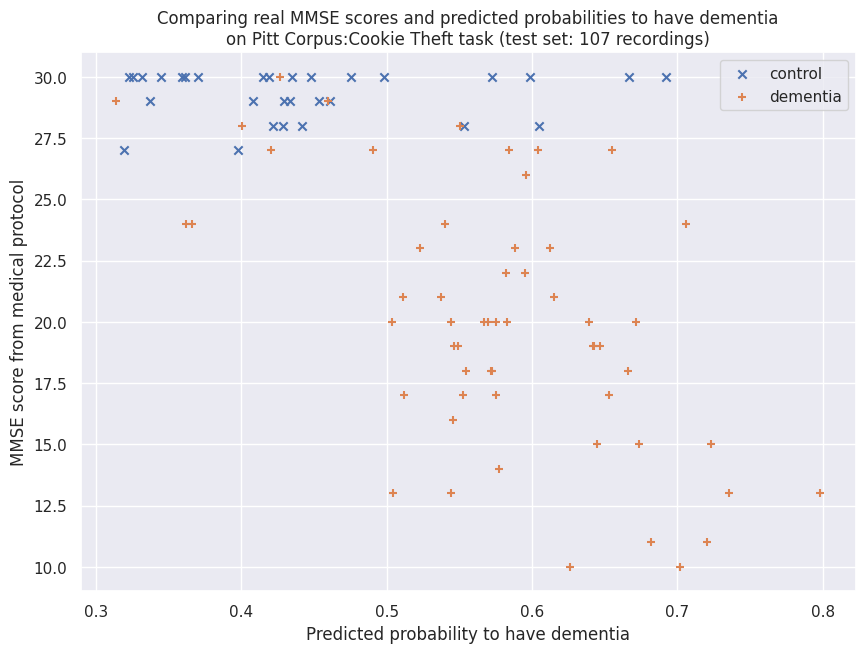

In [111]:
plt.figure(figsize=(10,7))
plt.scatter(x_points[labels==0], y_points[labels==0], label='control', marker='x')
plt.scatter(x_points[labels==1], y_points[labels==1], label='dementia', marker='+')
plt.xlabel('Predicted probability to have dementia')
plt.ylabel('MMSE score from medical protocol')
plt.title(f'Comparing real MMSE scores and predicted probabilities to have dementia\non Pitt Corpus:Cookie Theft task (test set: {len(test_set)} recordings)')
plt.legend()
plt.savefig('../reports/figures/scatter_plot.png')

In [112]:
from sklearn.metrics import confusion_matrix

In [113]:
labels_predictions = (x_points>=0.5).astype(int)

In [114]:
cm = confusion_matrix(y_true = labels, y_pred= labels_predictions)
tn, fp, fn, tp = cm.ravel()

print('Confusion Matrix:\n', cm)

print('\nTrue Negative:', tn)
print('True Positive:', tp)
print('\nFalse Positive:', fp)
print('False Negative:', fn)

Confusion Matrix:
 [[33  9]
 [10 55]]

True Negative: 33
True Positive: 55

False Positive: 9
False Negative: 10


In [115]:
accuracy = (tn+tp)/len(test_set)
print('Accuracy:', accuracy)

precision = (tp)/(tp+fp)
print('Precision:', precision)

recall = (tp)/(tp+fn)
print('Recall:', recall)

f1score = (2*tp)/(2*tp+fp+fn)
print('F1-score:', f1score)

Accuracy: 0.822429906542056
Precision: 0.859375
Recall: 0.8461538461538461
F1-score: 0.8527131782945736


#### Study False Positive

In [59]:
# loading data

import glob2
from pathlib import Path
import pickle

data_path = '../data/interim'

dementia_pickles = [ Path(p).absolute() for p in glob2.glob(data_path + '/dementia/pitt/cookie/*') ]
control_pickles = [ Path(p).absolute() for p in glob2.glob(data_path + '/control/pitt/cookie/*') ]

def unpickle_all_files(aList):
    result = {}
    for aPath in aList:
        with open(str(aPath), 'rb') as handle:
            b = pickle.load(handle)
        result[aPath.stem] = b
    return result

dementia_data = unpickle_all_files(dementia_pickles)
control_data = unpickle_all_files(control_pickles)

dementia_texts = {k:v['text'] for k,v in dementia_data.items()}
control_texts = {k:v['text'] for k,v in control_data.items()}

In [45]:
# get false positive indices

fp_list = (x_points>=0.5) & (labels == 0)
assert np.sum(fp_list) == fp

for i in range (len(fp_list)):
    if fp_list[i]:
        id_file = test_set[i].embedding_vector_path.split('/')[-1].split('.')[0]
        if id_file in control_texts.keys():
            text_to_display = control_texts[id_file]
        else:
            text_to_display = dementia_texts[id_file]
        print(id_file, ', proba:', round(x_points[i],3), ', MMSE:', y_points[i], '\n',text_to_display)
        print('\n\n')

676-0 , proba: 0.756 , MMSE: 24.0 
  Everything that you see happening in that picture, everything that's going on there. The boy and the girl are playing and he's gonna fall down off the ladder. And the mother's washing the dishes and it's flying out over the sink down to the floor. What else do you want me to tell you? That's all. Whatever you see happening. Is that it? Yeah, that's it. Okay, fine.



134-3 , proba: 0.571 , MMSE: nan 
  This is the last thing we have to do today. I'd like for you to take a look at this picture and tell me everything that you see going on in that picture, everything that's happening there. Well, there's a boy on the, I forget what you call it, on a stool, I guess, trying to climb up to get some cookies out of the cupboard. And his sister was standing there waiting for one. And then over here the lady was washing the dishes in the sink with the water in it, spilled all on the floor. Okay.



067-2 , proba: 0.519 , MMSE: 15.0 
  The little boy is up on 

#### Study False Negative

In [46]:
# get false negative indices

fn_list = (x_points<0.5) & (labels == 1)
assert np.sum(fn_list) == fn

for i in range (len(fn_list)):
    if fn_list[i]:
        id_file = test_set[i].embedding_vector_path.split('/')[-1].split('.')[0]
        print(id_file, ', proba:', round(x_points[i],3), ', MMSE:', y_points[i], '\n', dementia_texts[id_file])
        print('\n\n')

310-0 , proba: 0.258 , MMSE: 19.0 
  I'd like you to tell me all of the action that you see going on in that picture. Little boys come to a stool and it's going to upset these little cookies. And a sink is running over. Mother's drawing the dish. And the little girl is reaching up the cookies. Anything else? Anything else going on in that picture? And the little girl is going to look at the cookies.



350-0 , proba: 0.287 , MMSE: 19.0 
  What do you see going on in that picture? Girl washing dishes, I see that. Boy's putting up the cookie jar, getting some cookies out of the cookie jar. And his little sister is begging him, Oh hurry up, come on. And he's got the footstool. And his, her big sister is washing the dishes. That's the big sister of the mama, I don't know which that is. Is drying the dishes, putting them away. She's got the spigot on and the water is running. And there's her cups, she hasn't put them up yet. And he's up on the footstool, and he's got the cookie jars. What e